2025-04-29 20:14:02.397192: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745957642.743187      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745957642.818849      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


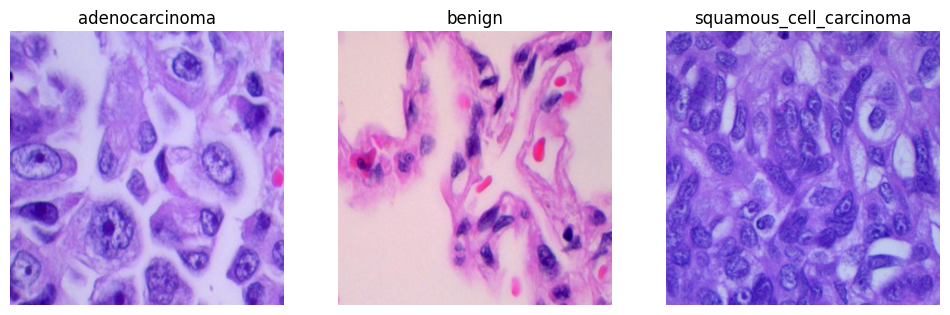

Found 12000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.


In [1]:
import numpy as np
import os
import shutil
import random
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

# Paths
DATASET_PATH = "/kaggle/input/lung-cancer-histopathological-images"
WORKING_DIR = "/kaggle/working/dataset"

# Copy dataset
if not os.path.exists(WORKING_DIR):
    shutil.copytree(DATASET_PATH, WORKING_DIR)

# Classes
classes = ["adenocarcinoma", "benign", "squamous_cell_carcinoma"]

# Visualize random images
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i, label in enumerate(classes):
    img_path = os.path.join(WORKING_DIR, label)
    img_file = random.choice(os.listdir(img_path))
    img = cv2.imread(os.path.join(img_path, img_file))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[i].imshow(img)
    axes[i].set_title(label)
    axes[i].axis("off")
plt.show()

# Settings
IMG_SIZE = (224, 224)
BATCH_SIZE = 1

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Load training data
train_data = train_datagen.flow_from_directory(
    WORKING_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

# Load validation data
val_data = val_datagen.flow_from_directory(
    WORKING_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)


In [20]:
def representative_data_gen():
    # Use original images without normalization
    raw_datagen = ImageDataGenerator().flow_from_directory(
        WORKING_DIR,
        target_size=IMG_SIZE,
        batch_size=1,
        class_mode='categorical',
        subset='validation',
        shuffle=False
    )
    
    for _ in range(100):
        img, _ = next(raw_datagen)
        # Convert to uint8 range (0-255)
        yield [img.astype(np.float32) * 255.0]

# Reload original model
model = tf.keras.models.load_model('/kaggle/input/squeezenet_lung_cancer.h5/tflite/default/1/squeezenet_lung_cancer.h5')

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.float32  # Changed to uint8
converter.inference_output_type = tf.float32  # Keep outputs float
tflite_model = converter.convert()

# Save
tflite_model_path = '/kaggle/working/squeezenet_lung_cancer_int8_v3.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print(f"Saved at: {tflite_model_path}")

Saved artifact at '/tmp/tmpu2g82zry'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_7')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  134554068167632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134554068169360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134554068170128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134554068167056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134554068169936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134554068172432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134554068168400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134554068170320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134554068168976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134550661260176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1345506612599

/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1745964199.672888      31 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1745964199.672922      31 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.


Found 0 images belonging to 3 classes.
Saved at: /kaggle/working/squeezenet_lung_cancer_int8_v3.tflite


fully_quantize: 0, inference_type: 6, input_inference_type: FLOAT32, output_inference_type: FLOAT32


In [23]:
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

val_data.reset()
y_true, y_pred = [], []

for _ in range(len(val_data)):
    img, label = next(val_data)
    
    # Convert to uint8 (0-255) without normalization
    input_data = img.astype(np.float32)
    
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    
    output = interpreter.get_tensor(output_details[0]['index'])
    y_pred.append(np.argmax(output))
    y_true.append(np.argmax(label))

In [25]:
import numpy as np
import tensorflow as tf
import time
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# ===== 1. INITIALIZE INTERPRETER =====
interpreter = tf.lite.Interpreter(model_path="/kaggle/working/squeezenet_lung_cancer_int8_v3.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# ===== 2. CHECK MODEL EXPECTATIONS =====
print(f"Model expects input type: {input_details[0]['dtype']}")
print(f"Model expects input shape: {input_details[0]['shape']}")

# ===== 3. MODIFIED INFERENCE LOOP ===== 
val_data.reset()
y_true, y_pred = [], []

for _ in range(len(val_data)):
    img, label = next(val_data)
    
    # COPY THIS PROCESSING BLOCK:
    if input_details[0]['dtype'] == np.uint8:
        input_data = (img * 255.0).astype(np.uint8)  # For uint8 models
    else:
        input_data = img.astype(np.float32)  # For float32 models
    
    # Ensure correct shape
    if input_data.shape != tuple(input_details[0]['shape']):
        input_data = np.resize(input_data, input_details[0]['shape'])
    
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    # END OF COPY BLOCK
    
    output = interpreter.get_tensor(output_details[0]['index'])
    y_pred.append(np.argmax(output))
    y_true.append(np.argmax(label))

# ===== 4. METRICS CALCULATION =====
print(f"\nAccuracy: {accuracy_score(y_true, y_pred) * 100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_true, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))

Model expects input type: <class 'numpy.float32'>
Model expects input shape: [  1 224 224   3]

Accuracy: 95.93%

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1000
           1       1.00      1.00      1.00      1000
           2       0.95      0.93      0.94      1000

    accuracy                           0.96      3000
   macro avg       0.96      0.96      0.96      3000
weighted avg       0.96      0.96      0.96      3000


Confusion Matrix:
[[948   3  49]
 [  2 998   0]
 [ 68   0 932]]
